In [1]:
### baseline
# establish baseline: Epochs (Done)

### dataset
# construct bigger dataset
# add background images to reduce FP
# augment with other coral images (?)

### other changes
# perform preprocessing of images
# analyse and understand dataset
# different image sizes (Bigger for better detection)
# images with a number of different transformations/augmentations
# changing hyperparameters (https://github.com/ultralytics/yolov5/issues/607)
# different model sizes

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# creating a home variable

import os
import glob
import re

HOME = os.getcwd()
print(HOME)

/content


In [4]:
# installation of libraries

!pip install ultralytics==8.0.20
!pip install roboflow --quiet

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/107.7 GB disk)


In [5]:
from ultralytics import YOLO
from IPython.display import display, Image
from roboflow import Roboflow
import numpy as np

In [6]:
# load the dataset

!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key="WifAHr5usNgAnytT03tt")
project = rf.workspace("ask-ishan").project("coral-detection-ci")
dataset = project.version(2).download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.20, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to Coral-Detection-CI-2 in yolov8:: 100%|██████████| 271/271 [00:00<00:00, 5354.59it/s]


In [ ]:
# train

%cd {HOME}
model = YOLO('yolov8m.pt')
results = model.train(data=f"{dataset.location}/data.yaml", epochs=300, plots=True)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

### Validation

In [7]:
# if training hasn't been done

%cd {HOME}

from pathlib import Path
Path(f'{HOME}/runs/detect/train/weights/').mkdir( parents=True, exist_ok=True )

/content


In [8]:
## load model
# model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

model = YOLO(f'/content/drive/MyDrive/Coastal Impact/yolo_model.pt')

In [ ]:
# validation
model.val(data=f"{dataset.location}/data.yaml")

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs
100%|██████████| 755k/755k [00:00<00:00, 25.9MB/s]
val: Scanning /content/datasets/Coral-Detection-CI-2/valid/labels... 33 images, 0 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<00:00, 780.15it/s]
val: New cache created: /content/datasets/Coral-Detection-CI-2/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.74s/it]
                   all         33        198      0.942      0.945      0.965      0.854
                 coral         33        165      0.902      0.891      0.935      0.722
                   ref         33         33      0.982          1      0.995      0.987
Speed: 3.1ms pre-process, 30.3ms inference, 0.0ms loss, 3.8ms post-process per image


### Metrics for our Results

In [9]:
def get_iou(box1, box2):
    """
    Implement the intersection over union (IoU) between box1 and box2

    Arguments:
        box1 -- first box, numpy array with coordinates (xmin, ymin, xmax, ymax)
        box2 -- second box, numpy array with coordinates
    """
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2

    xi1 = max(x11, x12)
    yi1 = max(y11, y12)
    xi2 = min(x21, x22)
    yi2 = min(y21, y22)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (x21 - x11) * (y21 - y11)
    box2_area = (x22 - x12) * (y22 - y12)
    union_area = box1_area + box2_area - inter_area
    # compute the IoU
    iou = inter_area / union_area
    return iou

In [10]:
# results
results = model.predict(source=f"{dataset.location}/valid/images")

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs


In [11]:
validation_image_names = list(glob.iglob("/content/datasets/Coral-Detection-CI-2/valid/images/*"))

In [12]:
# find a way around this for sure

results_list = []
for img in validation_image_names:
  result = model.predict(img)
  results_list.append(result[0])

In [129]:
iou_result_dict = {}
iou_result_per_image_dict = {}

for iou_thresh in np.arange(0.5, 1, 0.1):
  result_dict = {'tp_count':0,
                'fp_count':0,
                'true_masks_with_match':0,
                'true_masks_no_match':0,
                'mask_count_mismatch':0,
                "true_mask_count":0,
                'pred_mask_count':0,
                "true_multiple_matches":0,
                "pred_multiple_matches":0}

  for idx, result_i in enumerate(results_list):
    img_name = validation_image_names[idx][:-3] + "txt"
    img_name = re.sub('images', 'labels', img_name)

    with open(img_name) as f:
      textfile = f.read()

    true_classes = [int(i[0]) for i in textfile.strip().split("\n")]
    true_masks = [[float(j) for j in i.split(' ')[1:]] for i in textfile.strip().split("\n")]

    predicted_classes = result_i.boxes.cls
    predicted_masks = result_i.boxes.xyxyn

    n_true_masks = len(true_masks)
    n_predicted_masks = result_i.boxes.xyxyn.shape[0]

    array_mask_match = np.zeros(shape=(n_predicted_masks, n_true_masks))

    for idx_i, i_true_mask in enumerate(true_masks):
      x_i = i_true_mask[::2]
      y_i = i_true_mask[1::2]

      x_min = min(x_i)
      x_max = max(x_i)
      y_min = min(y_i)
      y_max = max(y_i)

      bbox_i = [x_min, y_min, x_max, y_max]
      for idx_j, j_predicted_mask in enumerate(predicted_masks):
        j_predicted_mask = list(j_predicted_mask.numpy())
        iou = get_iou(bbox_i, j_predicted_mask)
        current_true_class = true_classes[idx_i]

        condition_iou = iou>=iou_thresh
        condition_class = current_true_class==int(predicted_classes[idx_j].numpy())

        if condition_iou and condition_class:
          array_mask_match[idx_j, idx_i] += 1
          result_dict["tp_count"] += 1

    true_results = array_mask_match.sum(axis = 0)
    pred_results = array_mask_match.sum(axis = 1)

    result_dict["fp_count"] += list(pred_results).count(0)

    result_dict["true_masks_with_match"] += true_results[true_results>=1].shape[0]
    result_dict["true_masks_no_match"] += list(true_results).count(0)
    result_dict["mask_count_mismatch"] += int(array_mask_match.shape[0]!=array_mask_match.shape[1])
    result_dict["true_mask_count"] += array_mask_match.shape[1]
    result_dict["pred_mask_count"] += array_mask_match.shape[0]
    result_dict["true_multiple_matches"] += true_results[true_results>1].shape[0]
    result_dict["pred_multiple_matches"] += pred_results[pred_results>1].shape[0]
  iou_result_dict[iou_thresh] = result_dict
  iou_result_per_image_dict[iou_thresh] = {key: val/len(results_list) for key, val in result_dict.items()}

In [121]:
iou_result_dict[0.5]

{'tp_count': 190,
 'fp_count': 44,
 'true_masks_with_match': 186,
 'true_masks_no_match': 12,
 'mask_count_mismatch': 23,
 'true_mask_count': 198,
 'pred_mask_count': 234,
 'true_multiple_matches': 4,
 'pred_multiple_matches': 0}

In [130]:
iou_result_per_image_dict[0.5]

{'tp_count': 5.757575757575758,
 'fp_count': 1.3333333333333333,
 'true_masks_with_match': 5.636363636363637,
 'true_masks_no_match': 0.36363636363636365,
 'mask_count_mismatch': 0.696969696969697,
 'true_mask_count': 6.0,
 'pred_mask_count': 7.090909090909091,
 'true_multiple_matches': 0.12121212121212122,
 'pred_multiple_matches': 0.0}

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

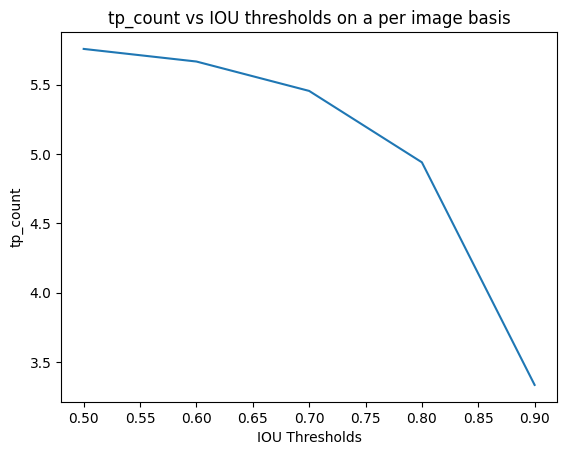

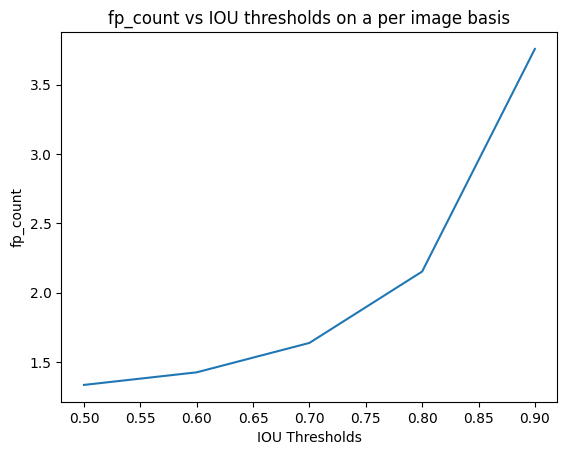

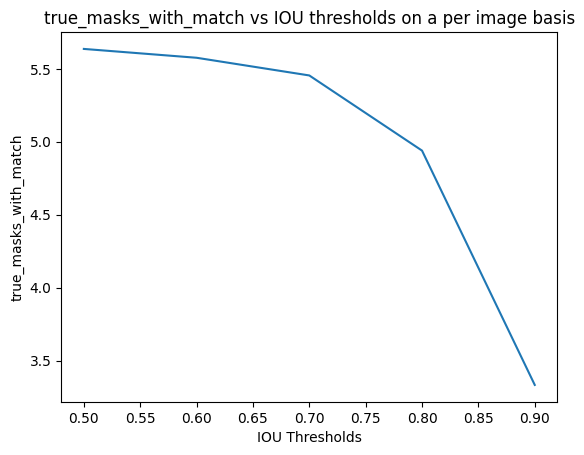

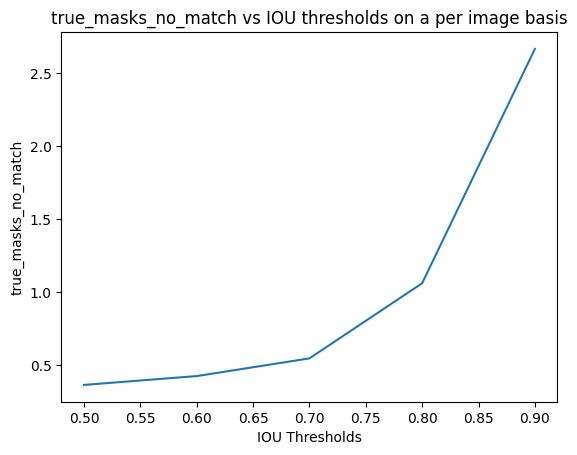

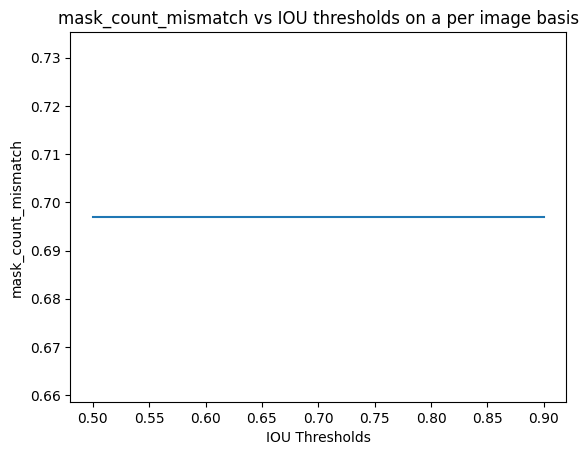

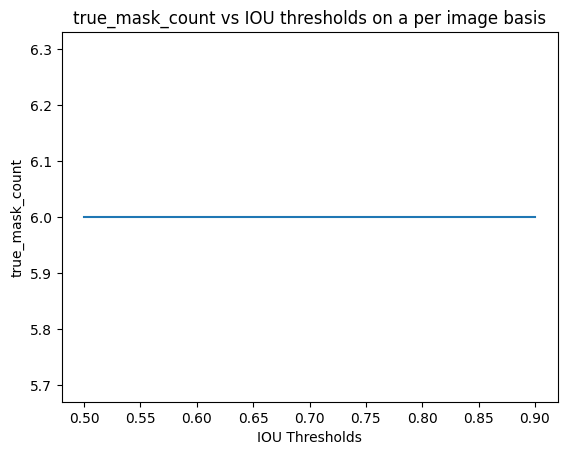

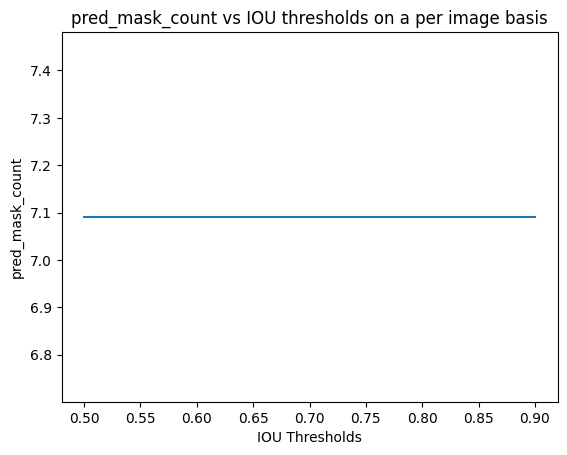

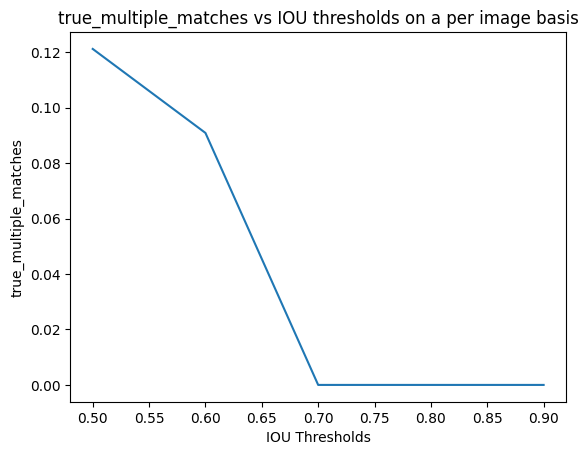

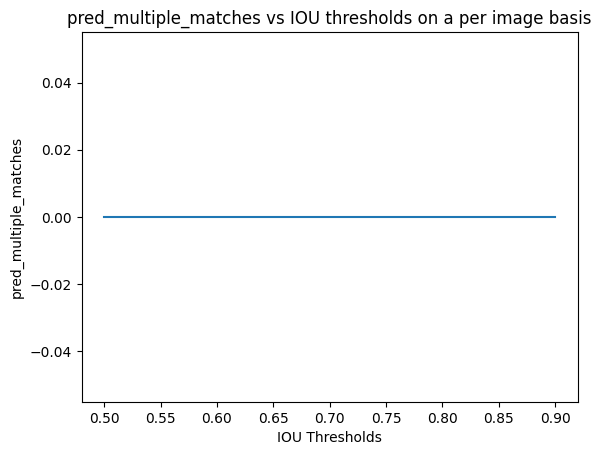

In [136]:
for key in iou_result_dict[0.5].keys():
  plt.plot(iou_result_per_image_dict.keys(), [val[key] for _, val in iou_result_per_image_dict.items()])
  plt.xlabel('IOU Thresholds')
  plt.ylabel(key)
  plt.title(f"{key} vs IOU thresholds on a per image basis")
  plt.show()

TO DO:

Checking validity of your metrics

Graphs of these metrics

per class stats

common metrics: Recall/precision, etc.

how do your figures compare with whats already being computed by Yolo

What is the average IOU for different results above?

Come up with all the cases/examples for these metrics and how they will change

### Testing

In [ ]:
# testing with selected model

## load model
model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

# Perform object detection on an image using the model
## pure inference
results = model("/content/datasets/Coral-Detection-CI-2/valid/images/*", save=True, plots=True)

# Export the model to ONNX format
# success = model.export(format='onnx')

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs
Results saved to runs/detect/predict


In [ ]:
# viewing detection results for specific images

import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[10:15]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [ ]:
%cd {HOME}
from ultralytics.utils.benchmarks import benchmark

# Benchmark on GPU
benchmark(model=f'{HOME}/runs/detect/train/weights/best.pt',
          data=f"{dataset.location}/data.yaml", imgsz=640, half=False, device=0)

/content


ModuleNotFoundError: ignored

### Rough

In [ ]:
%cd {HOME}

!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/valid/images save=True

In [ ]:
import cv2
img_path = "/content/datasets/Coral-Detection-CI-2/valid/images/20230106_130848_jpg.rf.0406748ab411cfd7120bdbc8e70c5578.jpg"
img = cv2.imread(img_path)

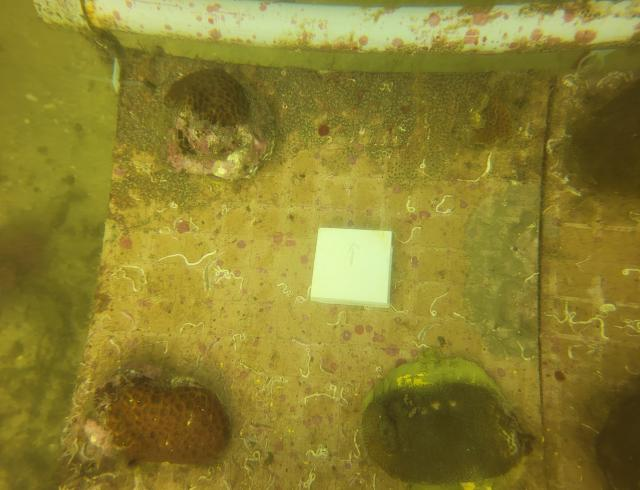

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [ ]:
bboxes = [[311., 228., 392., 304.],
        [101., 372., 233., 466.],
        [594., 394., 640., 489.],
        [569.,  79., 640., 201.],
        [360., 383., 520., 489.],
        [161.,  67., 275., 181.]]

In [ ]:
def draw_bboxes(bboxes, img):
  drawn_img = img.copy()
  for box in bboxes:
    x,y,x1, y1 = box
    h, w = y1-y, x1-x
    cv2.rectangle(drawn_img, (int(x), int(y)), (int(x + w), int(y + h)), (255,0,0), 4)

  return drawn_img

In [ ]:
bbox_image = draw_bboxes(bboxes, img)

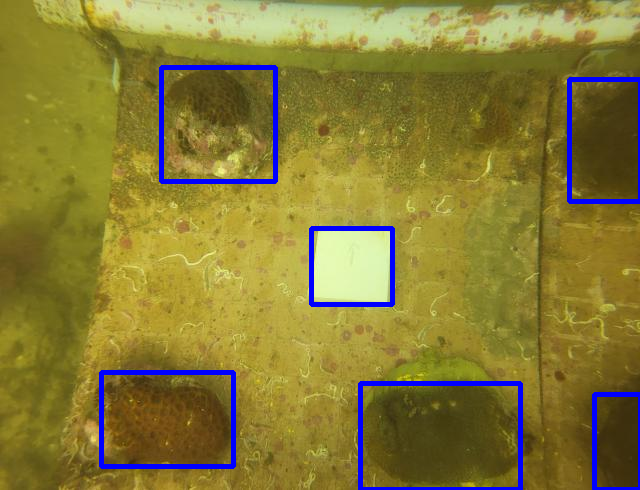

In [ ]:
cv2_imshow(bbox_image)